# AUDiaL: Evaluation Report

This notebook outlines the evaluation methodology of [AUDiaL](https://github.com/tomurillo/AUDiaL) (<strong>A</strong>ccessible <strong>U</strong>niversal <strong>Dia</strong>grams through <strong>L</strong>anguage), a Web prototype of a Natural Language Interface (NLI) to diagrams aiming to make statistical charts accessible to the visually impaired population.

Let us first load the required Python dependencies and utility methods:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

def analyze_data(measure, combine_first=False):
    """
    Read the indicated columns from demo_data and return statistics about it
    """
    means, stds, maxs, mins, x_combine, m_combine = [], [], [], [], [], []
    i = 0
    while True:
        try:
            i += 1
            if combine_first and i == 1:
                continue
            measures = demo_data[:]['{}__{}'.format(measure, i)]
            if combine_first and i == 2:
                measures = np.add(measures, demo_data[:]['{}__1'.format(measure)])  # Combine Task 1 and Task 2
            measures = measures[np.where(measures > -1)[0]]  # Missing values are set to -1; skip them
            x_combine.extend([i-1 for _ in range(len(measures))])
            m_combine.extend(measures)
            means.append(measures.mean())
            stds.append(measures.std())
            maxs.append(measures.max())
            mins.append(measures.min())
        except ValueError:
            break
    return means, stds, maxs, mins, x_combine, m_combine

## Evaluation Questions

AUDiaL is a Web-based prototype of a NLI to statistical diagrams, such as bar charts. It was designed and implemented in order to test a number of research questions:
<ol>
    <li>Is natural language a sufficient means for non-visual autonomous access to diagrams for blind persons?</li>
    <li>Can visualization semantics encoded via ontologies be efficiently retrieved via a Natural Language Interface (NLI)?</li>
    <li>How should a NLI be adapted for the specific needs of blind persons reading diagrams?</li>
</ol>

In order to answer these questions, AUDiaL was employed in a number of evaluation sessions with blind participants. In each session, participants were asked to solve tasks of increasing difficulty using both AUDiaL and their preferred means of accessing diagrams. Qualitative and quantitative measures of the efficacy of AUDiaL in comparison with traditional alternative diagram versions were gathered from analyzing several measures of how participants solved these tasks. 

## Method

In [2]:
CSV_DIR = 'data'
DEMO_FILE = 'AUDiaL_evaluation_anonymized.csv'
demo_data = np.genfromtxt(os.path.join(CSV_DIR, DEMO_FILE), dtype=None, delimiter=',', names=True, encoding=None)
N = demo_data.shape[0]
print('N={} participants.'.format(N))

N=8 participants.


## Effectiveness

In order to assess the success rate of the perfomed tasks, we measure task solving effectiveness. Effectiveness is measured by grading each answer to a task (or lack thereof) with the following scale:

<ul>
    <li>Task completed with ease: 0</li>
    <li>Task partially completed or completed with difficulty: 1</li>
    <li>Task failed: 2</li>
</ul>

Success or failure of tasks was determined by the experimenter, whereas the subjective difficulty of tasks was communicated by the participants by answering the following feedback question after answering each task:


<section>
    <h5>Were you able to complete the task?:</h5>
    <ol>
        <li>Yes, with ease</li>
        <li>Yes, but with diffculty</li>
        <li>I am not sure</li>
        <li>No, I failed to complete the task</li>
    </ol>
<section>
    
If a participant failed to complete the task, a score of 2 was assigned to the answer regardless of their subjective impression of whether they had been able to solve it. If the participant answered the task in a partial manner, a score of 1 was also given regardless of the feedback given. If the task was answered correctly, then a score of 0 was assigned to the answer if the participant chose "Yes, with ease"  to the feedback question; otherwise, the answer was given a score of 1.

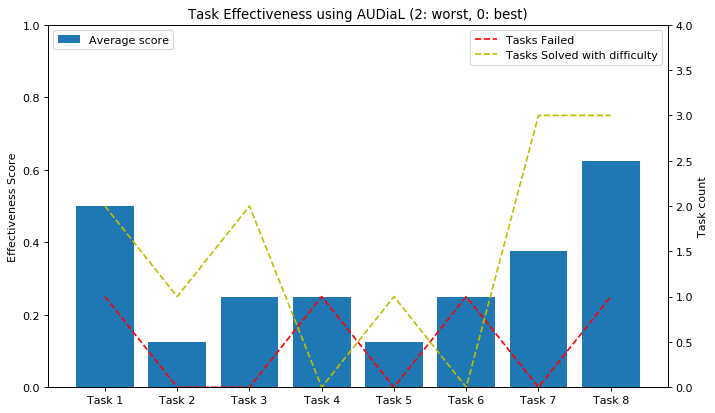

In [3]:
# Collect statistics
means, stds, maxs, mins, x_comb, eff_comb = analyze_data('Dialogue__Efficiency')
# Count failed tasks
failed_counts = np.zeros((len(means),), dtype=int)
failed_idx = np.where(np.array(eff_comb) == 2)
failed, f_count = np.unique(np.array(x_comb)[failed_idx], return_counts=True)
failed_counts[failed] = f_count
# Count tasks solved with difficulty
solved_diff_counts = np.zeros((len(means),), dtype=int)
solved_diff_idx = np.where(np.array(eff_comb) == 1)
solved_diff, sd_count= np.unique(np.array(x_comb)[solved_diff_idx], return_counts=True)
solved_diff_counts[solved_diff] = sd_count

# Horizontal axis values (zero-indexed)
x = np.arange(len(means))

# Plot means
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.set_ylim([0,1])
ax1.bar(x, means, label='Average score')
ax1.set_ylabel('Effectiveness Score')
ax1.legend(loc='upper left')
# Plot unsuccessful tasks
ax2 = ax1.twinx()
ax2.set_ylim([0,4])
ax2.set_ylabel('Task count')
plt.plot(x, failed_counts, linestyle='--', color='r',label='Tasks Failed')
plt.plot(x, solved_diff_counts, linestyle='--', color='y',label='Tasks Solved with difficulty')
ax2.legend(loc='upper right')
# Rest of plot
xticks = ['Task {}'.format(i) for i in range(1, len(means)+1)]
plt.xticks(x, xticks)
plt.title('Task Effectiveness using AUDiaL (2: worst, 0: best)')
plt.show()

## Efficiency

Efficiency was measured by observing how long it took participants to complete those tasks that were given at least a partially correct answer. Time was kept via analyzing the system logs for AUDiaL, and by manually measuring in the case of table-based tasks. Manual timekeeping is not as accurate as system log timestamps are, thus they are rounded to the nearest minute.

Because both the answers for *Task 1* and *Task 2* could be fetched from the diagram's summary, most participants required a very short time to complete *Task 2*. For this reasons, the times of *Task 1* and *Task 2* have been combined into a single timestamp in the following analysis.

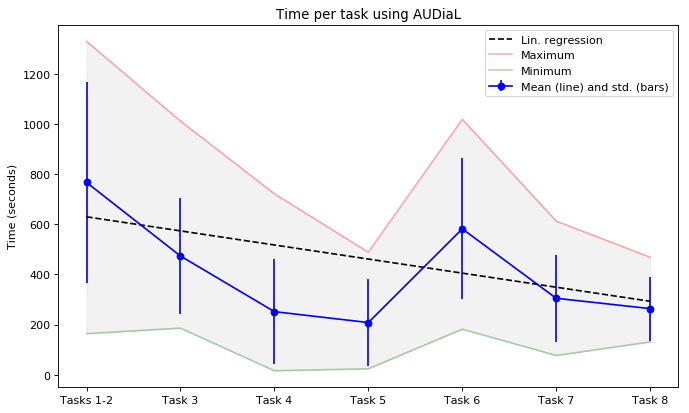

In [4]:
# Collect statistics
means, stds, maxs, mins, x_comb, t_comb = analyze_data('Dialogue__Time', combine_first=True)

# Horizontal axis values (zero-indexed)
x = np.arange(len(means))

# Linear regression of datapoints
linfit = np.polyfit(x_comb, t_comb, 1)
linfit_fn = np.poly1d(linfit)

# Plot all
xticks = ['Tasks 1-2']
xticks.extend(['Task {}'.format(j) for j in range(3, len(means) + 2)])
fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.errorbar(x, means, stds, linestyle='-', marker='o', color='b', label='Mean (line) and std. (bars)')
plt.plot(x, linfit_fn(x), '--k', label='Lin. regression')
plt.plot(x, maxs, color='r', alpha=.3, label='Maximum')
plt.fill_between(x, mins, maxs, color='silver', alpha=.2)
plt.plot(x, mins, color='g', alpha=.3, label='Minimum')
plt.xticks(x, xticks)
plt.ylabel('Time (seconds)')
plt.title('Time per task using AUDiaL')
plt.legend(loc='upper right')
plt.show()

From the plot above, the following conclusions can be derived:
<ul>
    <li>As shown by the linear regression fitting line, time per task decreases with time as participants got used to the Web prototype. This fact is exacerbated if we consider that latter tasks are harder to asnwer than the previous ones.</li>
    <li>Tasks 1 and 2 took users the longest to solve, as participants spent a long time reading the summary and exploring the diagrams.</li>
</ul>